<a href="https://colab.research.google.com/github/alpayozkan/Dynamic-Inference-with-Neural-Interpreters/blob/main/NerualInterpreters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

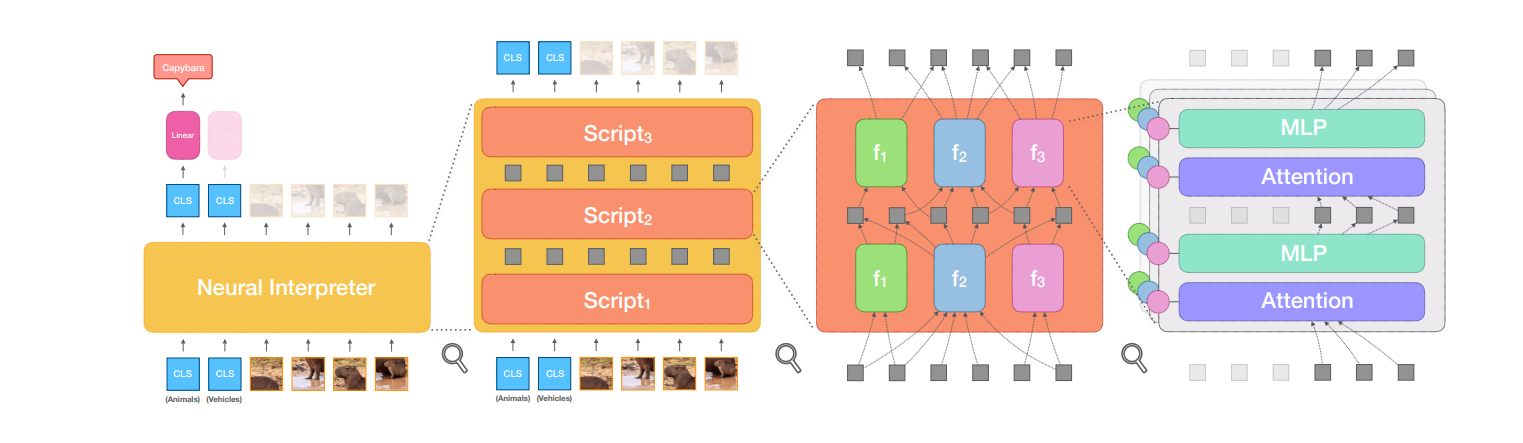

# Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
# Main Hyperparameters
img_size = 32                           # Dimension of spatial axes of input images
patch_size = 4                          # Patch size
in_channels = 3                         # Dimension of input channels
embed_dim = 256                         # Dimension of embeddings
batch_size = 128                        # Number of batch
epochs = 100                            # Number of epochs
dim_c = 192                             # Dimension of 'code' vector
dim_inter = 192                         # Dimension of intermediate feature vector
ns = 1                                  # Number of 'scripts'
ni = 8                                  # Number of 'function' iterations
nl = 1                                  # Number of LOCs
nf = 5                                  # Number of 'function's
n_cls = 3                               # Number of CLS tokens
n_heads = 4                             # Number of heads per LOC
loc_features = 128                      # Number of features per LOC head
type_inference_depth = 2                # Type Inference MLP depth
type_inference_width = 192              # Type Inference MLP width 
treshold = 1.4                          # Trunctation Parameter
signature_dim = 24                      # Dimension of type_space

# Pretraining Hyperparameters # Dimension of input channels
frozen_function_codes = False           # Required for pretraining
frozen_function_signatures = False      # Required for pretraining

# Optimization Hyperparameters          
beta1 = 0.9                             # Adam Optimizer beta1 parameter
beta2 = 0.999                           # Adam Optimizer beta2 parameter
lr = 1e-8                               # Learning Rate

# Dataloader 

In [3]:
def get_data_loader(datasetname, root, batch_size, transform):
  '''
  Digits dataset is a combination of three related datasets:
      1. SVHN 
      2. MNISTM   -> RESIZE all of them to [32 x 32]
      3. MNIST
  '''
  if datasetname == 'digits':
    # Get the dataset
    svhn = datasets.SVHN(root=root, 
                         split='train',
                         download=True,
                         transform=transform)
    # Get the loader
    loader = DataLoader(
        svhn,
        batch_size = batch_size,
        num_workers = 2,
        pin_memory = True,
        shuffle= True
    )

  return loader

In [4]:
# Parameters for dataset
datasetname = 'digits'
root = '.'
batch_size = 128
transform = transforms.Compose([
                  transforms.Resize((32, 32)),
                  transforms.ToTensor()])
loader = get_data_loader(datasetname, root, batch_size, transform)

Using downloaded and verified file: ./train_32x32.mat


In [5]:
data = next(iter(loader))

In [6]:
print('data[0]:', data[0].size())
print('data[1]:', data[1].size())

data[0]: torch.Size([128, 3, 32, 32])
data[1]: torch.Size([128])


In [7]:
def visualize_data(loader):
  # Get a sample of data
  samples = next(iter(loader))[0]
  
  # Determine grid size
  grid_width = 8 
  grid_height = 8
  
  # Create the grid
  image_grid = make_grid(samples[:grid_width*grid_height], nrow=grid_width)
  
  # Visualization arrangement
  plt.rcParams['figure.figsize'] = [grid_height, grid_width]
  plt.imshow(image_grid.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

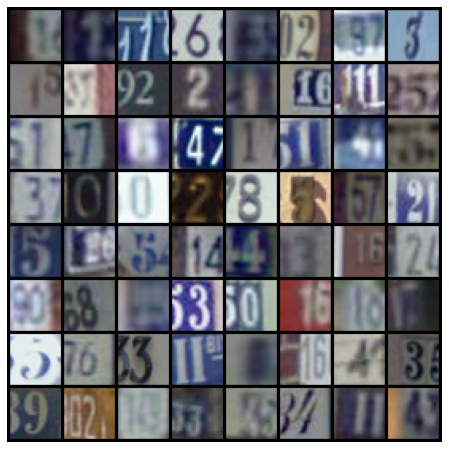

In [8]:
visualize_data(loader)

# Patch Embedding

In [9]:
class PatchEmbedding(nn.Module):
  '''
  Given images are linearly embedded via Patch Embedding in order to get tokens.

  Args:
  -----  
    img_size    [int]: Images are assumed to be square
    patch_size  [int]: Images are divided into patches of size `patch size`
    in_channels [int]: Number of input channels of given images
    embed_dim   [int]: Final embedding dimension

  Attributes:
  -----------
    n_patches   [int]:  Number of total patches at the end
    projection  [Conv]: Patch extractor
  '''

  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.embed_dim = embed_dim
    
    self.n_patches = (img_size // patch_size) ** 2
    self.projection = nn.Conv2d(in_channels = in_channels, 
                                out_channels = embed_dim, 
                                kernel_size = patch_size, 
                                stride = patch_size)
  
  def forward(self, x):
    '''
    Args:
    -----
      x [Tensor(B x C x H x W)]: Input images
    
    Returns:
    --------
      projected [Tensor(B x N x E)] where N stands for n_patches & E stands for embed_dim
    '''
    projected = self.projection(x).flatten(2).transpose(1, 2) 
    return projected

In [10]:
# TEST
img = data[0]
patch_embedding = PatchEmbedding(img_size, 
                                 patch_size, 
                                 in_channels, 
                                 embed_dim)

embeddings = patch_embedding(img)
embeddings.size()

torch.Size([128, 64, 256])

# MLP

In [11]:
class MLP(nn.Module):
  '''
  Type Inference MLP module. 
  
  Args:
  ----
    in_features     [int]: Dimension of input features and output features
    hidden_features [int]: Dimension of intermediate features
    out_features    [int]: Dimension of the signature
    
  Returns:
  -------
    t [Tensor()]: Type vector
  '''
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.net = nn.Sequential(
              nn.Linear(in_features, hidden_features),
              nn.GELU(),
              nn.Linear(hidden_features, out_features)
              )

  def forward(self, embeddings):
    '''
    Args:
    ----
      embeddings [Tensor(B x N x E)]: 

    Returns:
    --------
      type_vector [Tensor(B x N x S)] where S stands for signature dimension
    '''
    type_vector = self.net(embeddings)
    return type_vector 

In [12]:
# TEST
mlp = MLP(embed_dim, type_inference_width, signature_dim)
type_vectors = mlp(embeddings)
type_vectors.size()

torch.Size([128, 64, 24])

# TypeInference

In [13]:
class TypeMatching(nn.Module):
  '''
  Enables the learned routing of input set through functions.
    
    1. Given a set of element x_i, extract its type vector t_i
    2. Compute `Compatibility`
    3. If this compatibility is larger than treshold, permit f_u to access x_i.
  '''
  def __init__(self, in_features, hidden_features, out_features, treshold):
    super().__init__()
    self.treshold = treshold
    self.type_inference = MLP(in_features, hidden_features, out_features)
    self.register_parameter('sigma', nn.Parameter(torch.ones(1)))

  def forward(self, x, s):
    '''
    Args:
    -----
      x [Tensor(B x N x E)]: Embeddings
      s [Tensor(F x S)]
    
    Attributes:
      t [Tensor(B x N x S)]
      compatilibity_score [Tensor(B x F x N)]: Parallelized computation score of compatibility score. F stands for # Functions.
      compatilibity_hat   [Tensor(B x F x N)]: Negative exponentiated version of compatibility score
    '''
    t = self.type_inference(x)
    compatibility_hat = self.get_compatilibity_score(t, s)
    
    # Softmax 
    compatibility_norm = compatibility_hat.sum(dim=1).unsqueeze(1) + 1e-5
    compatibility = torch.div(compatibility_hat, compatibility_norm)
    
    return compatibility

  def get_compatilibity_score(self, t, s):
    distance = (1 - t @ s.transpose(0, 1))
    return torch.where(distance > self.treshold, torch.exp(-distance/self.sigma), torch.tensor(0, dtype=torch.float)).transpose(1, 2)

In [14]:
# TEST
s = torch.ones(nf, signature_dim)
type_matching = TypeMatching(embed_dim, type_inference_width, signature_dim, treshold)
out = type_matching(embeddings, s)
out.size() # Expected Size: [B x F x N]

torch.Size([128, 5, 64])

# ModLin

In [86]:
class ModLin(nn.Module):
    '''
    Linear Layer conditioned by `code` vector. 
    
    Args:
    ----
      code  [Tensor(dcond x 1)]: Code vector of a `function`.
      dout  [int]: Dimension of the output of the projection.
      din   [int]: Dimension of the input  of the projection.
      dcond [int]: Dimension of the code vector.
    
    Attributes:
    -----------
      W_c [Tensor(din x dcond)]: Projection matrix of condition vector
      b   [Tensor(dout)]:        bias vector 
      W   [Tensor(dout x din)]:  Projection matrix of conditioned vector

    '''
    def __init__(self, code, dout, din, dcond):
      super().__init__()
      self.c = code
      self.register_parameter('w_c', nn.Parameter(torch.empty(din, dcond)))
      self.register_parameter('b', nn.Parameter(torch.empty(dout)))
      self.register_parameter('W', nn.Parameter(torch.empty(dout, din)))
      self.norm = torch.nn.LayerNorm(din)

    def forward(self, x):
      '''
      Performs linear projection of embeddings in `din` dimensional space onto
      `dout` dimensional space by fusing [conditioning] embeddings [x] with normalized `code`
      vectors.
      '''  
      out = self.norm(torch.matmul(self.w_c, self.c))
      out = x * out
      out = torch.matmul(out, self.W.transpose(0, 1))+self.b
      return out

In [88]:
# TEST
code = torch.ones(dim_c)
dout = 74
din = 256
dcond = dim_c
modlin = ModLin(code, dout, din, dcond)
modlin_out = modlin(embeddings)
modlin_out.size()

torch.Size([128, 64, 74])

# ModMLP

In [89]:
class ModMLP(nn.Module):
  '''
  Combination of ModLin Layers with the GELU activation function.

  Args:
  ----
    n_layers [int]: Number of ModLin layers
    code     [Tensor(dcond x 1)]: Code vector of a `function`.
    dout     [int]: Dimension of the output projection
    din      [int]: Dimension of the input  projection
    dcond    [int]: Dimension of the code vector
    activ    [nn.Module]: Activation function applied after every ModLin Layer
  
  Attributes:
  -----------
    modlin_blocks [List[ModLin]]: Stack of ModLin layers 
  '''
  def __init__(self, n_layers, code, dout, din, dcond, activ=nn.GELU):
      super().__init__()
      self.modlin_blocks = [ModLin(code, dout, din, dcond), activ()]
      
      for i in range(n_layers-1):
        self.modlin_blocks.append(ModLin(code, dout, dout, dcond))
        self.modlin_blocks.append(activ())
     
      self.modlin_blocks = nn.Sequential(*self.modlin_blocks)
  
  def forward(self, x):
      out = self.modlin_blocks(x)
      return out

In [92]:
# TEST
n_layers = 3
modmlp = ModMLP(n_layers, code, dout, din, dcond)
modmlp_out = modmlp(embeddings)
modmlp_out.size()

torch.Size([128, 64, 74])

# White-Box Test

In [55]:
# 1 batch, 2 tokens, 4 dimensional
embed_dim_test = 4
embeddings_test = torch.tensor([[[-20, 50, -4, 16],
                                 [30, -40, -5, -1]]], dtype=torch.float)
embeddings_test.size()

torch.Size([1, 2, 4])

In [56]:
s_test = torch.rand(nf, signature_dim)
type_matching_test = TypeMatching(embed_dim_test, type_inference_width, signature_dim, treshold)
out_test = type_matching_test(embeddings_test, s_test)
out_test.size() # Expected Size: [B x F x N]

torch.Size([1, 5, 2])

In [57]:
out_test

tensor([[[0.0000e+00, 3.0112e-08],
         [9.6579e-03, 9.5613e-04],
         [9.7916e-01, 4.5405e-07],
         [8.8039e-03, 2.8508e-11],
         [0.0000e+00, 1.1043e-09]]], grad_fn=<DivBackward0>)

# ModAttn

In [ ]:
class ModAttn(nn.Module):
  '''

  '''
  def __init__(self, code, din, dcond, n_heads, attn_prob = 0.0):
    super().__init__()
    self.c = code
    self.q_modlin = ModLin(code, din, din, dcond)
    self.k_modlin = ModLin(code, din, din, dcond)
    self.v_modlin = ModLin(code, din, din, dcond)
    self.head_dim = din // n_heads
    self.attn_drop = nn.Dropout(attn_prob)
  
  def forward(self, x):
    q = 
    
